# TransFER

In [1]:
import numpy as np
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.init as init


In [2]:
class FERDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
        self.data = []

        for label, emotion in enumerate(self.classes):
            emotion_dir = os.path.join(root_dir, emotion)
            for filename in os.listdir(emotion_dir):
                img_path = os.path.join(emotion_dir, filename)
                if os.path.exists(img_path):  
                    self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]

        for _ in range(3):  
            try:
                image = Image.open(img_path).convert('L')  
                if self.transform:
                    image = self.transform(image)
                return image, label
            except FileNotFoundError:
                time.sleep(1) 
        raise FileNotFoundError(f"Failed to open {img_path} after multiple attempts.")

transform = transforms.Compose([
    transforms.Grayscale(),  
    transforms.Resize((230, 230)),  
    transforms.RandomRotation(15), 
    transforms.RandomCrop(224, padding=8),  
    transforms.RandomHorizontalFlip(),  
    transforms.ToTensor(),
])

train_dataset = FERDataset('C:/Users/user/Desktop/DLProject/FER-2013/train', transform=transform)
test_dataset = FERDataset('C:/Users/user/Desktop/DLProject/FER-2013/test', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0) 

In [3]:
class ModifiedResNet(nn.Module):
    def __init__(self):
        super(ModifiedResNet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        init.kaiming_normal_(resnet.conv1.weight, mode='fan_out', nonlinearity='relu')
        self.features = nn.Sequential(*list(resnet.children())[:-2])

    def forward(self, x):
        return self.features(x)

class MAD(nn.Module):
    def __init__(self, drop_rate):
        super(MAD, self).__init__()
        self.drop_rate = drop_rate

    def forward(self, x):
        if self.training:
            binary_mask = torch.bernoulli(torch.full(x.size(), 1 - self.drop_rate)).to(device)
            return x * binary_mask
        return x

class TransFER(nn.Module):
    def __init__(self, num_classes=7):
        super(TransFER, self).__init__()
        self.stem_cnn = ModifiedResNet()
        self.local_cnn1 = nn.Conv2d(512, 2048, kernel_size=3, padding=1)
        self.local_cnn2 = nn.Conv2d(512, 2048, kernel_size=3, padding=1)
        self.mad = MAD(drop_rate=0.6)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=2048, nhead=8, batch_first=True),  
            num_layers=8
        )
        self.classifier = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.stem_cnn(x)
        x1 = self.local_cnn1(x)
        x2 = self.local_cnn2(x)
        x1 = self.mad(x1)
        x2 = self.mad(x2)
        x = torch.cat((x1, x2), dim=2)
        x = x.permute(0, 2, 3, 1).flatten(1, 2)
        x = self.transformer_encoder(x)
        x = self.classifier(x.mean(dim=1))
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransFER(num_classes=7).to(device)  
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15, 30], gamma=0.1)

num_epochs = 1
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct = 0 
    total = 0 

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss/len(train_loader):.4f}, Training Accuracy: {100.*correct/total:.2f}%")

c:\Users\user\anaconda3\envs\python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/1, Training Loss: 2.0387, Training Accuracy: 19.83%


Accuracy: 29.95263304541655%
Confusion Matrix:


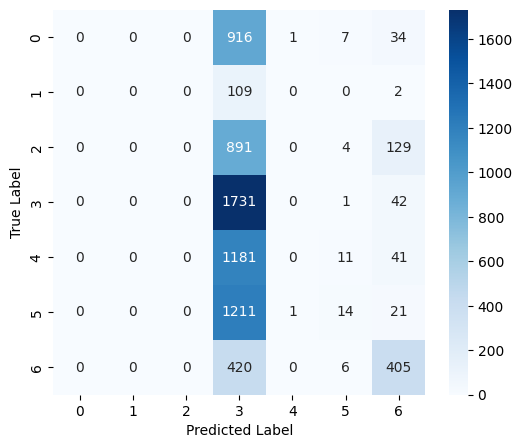

c:\Users\user\anaconda3\envs\python\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 0.1923611683957987
Recall: 0.2995263304541655
F1 Score: 0.17000388684148568
Class 0 AUC: 0.5926531694513624
Class 1 AUC: 0.7745593336367356
Class 2 AUC: 0.5921705839189958
Class 3 AUC: 0.7008397888073221
Class 4 AUC: 0.5766785558618235
Class 5 AUC: 0.6566878363408549
Class 6 AUC: 0.8580295190484831


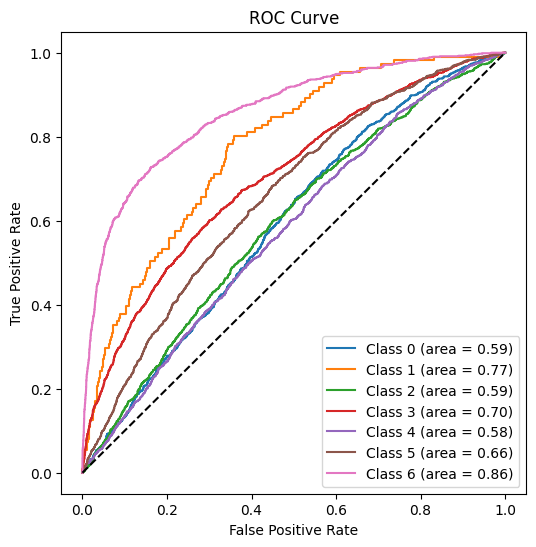

In [4]:
model.eval()
correct = 0
total = 0
all_labels = []
all_preds = []
all_outputs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Appending labels and predictions for further evaluation
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_outputs.extend(outputs.cpu().numpy())

print(f"Accuracy: {100 * correct / total}%")

cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

num_classes = 7
all_labels_bin = label_binarize(all_labels, classes=[i for i in range(num_classes)])
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], np.array(all_outputs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(num_classes):
    print(f"Class {i} AUC: {roc_auc[i]}")

plt.figure(figsize=(6, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show() 